In [1]:
import os
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import lag_plot, autocorrelation_plot, bootstrap_plot, radviz

import copy
import gc
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv

import decorators

In [2]:
@decorators.time_log("logs/timing/interpolation.jl")
def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {int(series.mean())}, σ = {int(series.std())}")
##


@decorators.time_log("logs/timing/interpolation.jl")
def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var"]
    
    if kind in valid_kinds:
        df.groupby(df.index.dayofyear)[colum_name].\
            apply(eval(f"np.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.dayofyear)[colum_name].\
                    apply(eval(f"np.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception("kind should be `mean` (`std` or `var`)")
##

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def ez_bolus_indices(
    df: pd.DataFrame, 
    kind: Optional[str] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    _kind_dict = {
        "meal": ["BWZ Carb Input (grams)"], 
        "correction": ["BWZ Correction Estimate (U)"], 
        "both": ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    }
    if kind not in _kind_dict.keys():
        warnings.warn(f"Invalid kind, use of {list(_kind_dict.keys())}.")
        warnings.war("Defaulted to 'both'")
        kind = "both"
    
    columns = _kind_dict[kind]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def bolus_indices_explicit(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##

def basal_only(
    df: pd.DataFrame, 
    column: str = "Sensor Glucose (mg/dL)",
    time_window: Dict[str,int] = {
        "hours": 2, 
        "minutes": 30
    }
) -> pd.DataFrame:
    """
    """
    basal = df.copy()
    _td = dt.timedelta(**time_window)
    for uid in bolus_indices(basal):
        real = uid + _td
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean") -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var"]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}'].
                apply(eval(f"np.{kind}")).
                    plot(label=f"{i} ") 
            for i in [10, 20, 30]
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##  

In [150]:
def bolus_only(
    df: pd.DataFrame, 
    column: str = "Sensor Glucose (mg/dL)",
    time_window: Dict[str,int] = {
        "hours": 2, 
        "minutes": 45
    }, 
    kind: Optional[str] = None
) -> pd.DataFrame:
    """
        kind: 'meal'
              'correction'
              'both'
               
               defaults to 'both'
    """
    bolus = df.copy()
    bolus["save"] = False
    
    
    _kind_dict = {
        "meal": ["BWZ Carb Input (grams)"], 
        "correction": ["BWZ Correction Estimate (U)"], 
        "both": ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    }
    if kind is None:
        warnings.warn("Kind defaulted to 'both'")
        kind = "both"
    if kind not in _kind_dict.keys():
        warnings.warn(f"Invalid kind, use one of {list(_kind_dict.keys())}.")
        
    
    _td = dt.timedelta(**time_window)
    
    for uid in bolus_indices_explicit(bolus, columns=_kind_dict[kind]):
        real = uid + _td
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        bolus.loc[uid:closest, "save"] = True

    bolus.loc[ bolus.save == False, "Sensor Glucose (mg/dL)"] = np.nan
    
    return bolus
##

def overlapping_dayplot(
    df: pd.DataFrame,
    sns_scatter_kw: Dict[str,Any] = {
        "x": "minutes",
        "y": "Sensor Glucose (mg/dL)",
    }
) -> NoReturn:
    """
    """
    sns.scatterplot(
        data=df,
        hue=df.index.date,
        **sns_scatter_kw
    )
##

In [3]:
random_seed = 123456

In [4]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.max_open_warning'] = False

In [5]:
!ls interpolated/ | grep 20-06

NG1988812H_Maganna_Gustavo_(24-05-20)_(20-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(29-03-20)_(20-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(7-06-20)_(20-06-20)_interpolated.csv


In [37]:
data = import_csv("interpolated/NG1988812H_Maganna_Gustavo_(24-05-20)_(20-06-20)_interpolated.csv")

/Users/gml/Library/Caches/pypoetry/virtualenvs/diabetes-analysis--6n-IUK1-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,6,7,32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [38]:
data.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'Preset Bol

In [40]:
my_columns = [
    'BG Reading (mg/dL)', 'Basal Rate (U/h)',
    
    'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
    'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
    'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
    'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
    'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
    'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
    'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
    'BWZ Active Insulin (U)', 'Bolus Number',
    'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
    'Final Bolus Estimate', 'Insulin Action Curve Time',
    
    'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 
    'ISIG Value', 'Event Marker',
    
    'hour', 'minute', 'x(t)', 'y(t)'
]
y = data[my_columns]

In [137]:
#y[ y["ISIG Value"] <= 10 ]

In [41]:
print("start \t:", y.index[0])
print("end \t:", y.index[-1])

start 	: 2020-05-20 13:55:00
end 	: 2020-06-20 23:21:00


In [117]:
latest = y.loc["2020-06-15":"2020-06-20", :]

In [118]:
#deltas = [1, 5, 15, 30, 60, 120]
#woo = pd.DataFrame()
#for i in deltas:
 #   woo[f"Dg{i}"] = bolos["Sensor Glucose (mg/dL)"].diff(i)
  #  woo[f"D2g{i}"] = woo[f"Dg{i}"].diff(1)
#bolos = bolos.join(woo)

In [119]:
def add_deltas(
    df: pd.DataFrame,
    column_name: str = "Sensor Glucose (mg/dL)", 
    deltas: List[int] = [1, 5, 15, 30, 60, 120]
) -> pd.DataFrame:
    """
    """
    
    _woo = pd.DataFrame()
    for i in deltas:
        _woo[f"Dg{i}"] = df[column_name].diff(i)
        _woo[f"D2g{i}"] = woo[f"Dg{i}"].diff(1)
    return df.join(_woo)
##

In [120]:
bolos = bolus_only(latest)
comidas = bolus_only(latest, kind="meal")
correciones = bolus_only(latest, kind="correction")

/Users/gml/Library/Caches/pypoetry/virtualenvs/diabetes-analysis--6n-IUK1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Kind defaulted to 'both'


In [121]:
bolos, comidas, correciones = map(add_deltas, [bolos, comidas, correciones])

2020-06-15    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-16    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-17    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-18    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-19    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-20    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Dg15, dtype: object

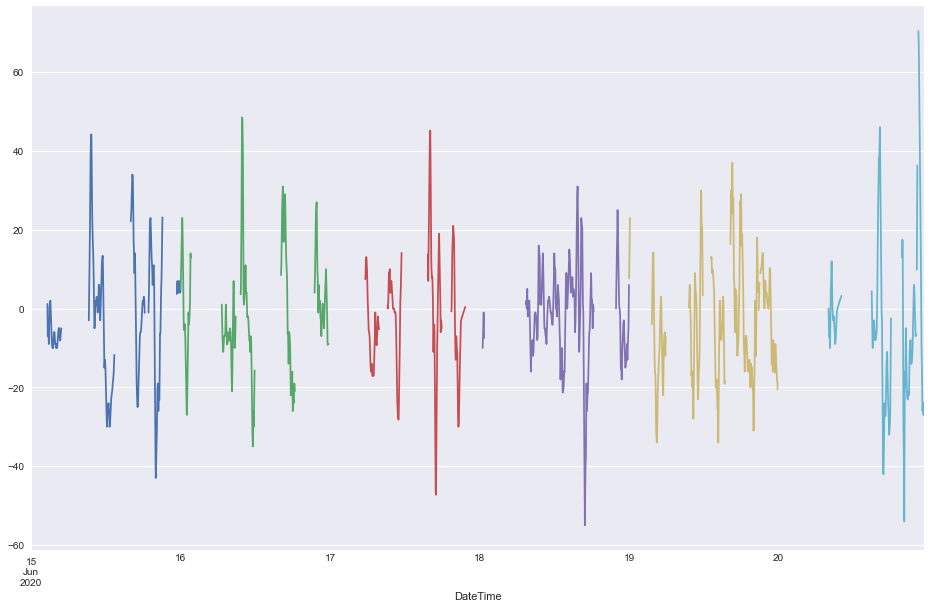

In [122]:
bolos["Dg15"].groupby(bolos.index.date).plot()

In [109]:
#bolos[["Basal Rate (U/h)", "Sensor Glucose (mg/dL)"]].plot(subplots=True, kind="line")
bolos.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Bolus Volume Selected (U)',
       'Bolus Volume Delivered (U)', 'Bolus Duration (h:mm:ss)', 'Prime Type',
       'Prime Volume Delivered (U)', 'Alarm', 'Suspend', 'Rewind',
       'BWZ Estimate (U)', 'BWZ Target High BG (mg/dL)',
       'BWZ Target Low BG (mg/dL)', 'BWZ Carb Ratio (g/U)',
       'BWZ Insulin Sensitivity (mg/dL/U)', 'BWZ Carb Input (grams)',
       'BWZ BG Input (mg/dL)', 'BWZ Correction Estimate (U)',
       'BWZ Food Estimate (U)', 'BWZ Active Insulin (U)', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Insulin Action Curve Time',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 'ISIG Value',
       'Event Marker', 'hour', 'minute', 'x(t)', 'y(t)', 'save', 'Dg1', 'D2g1',
       'Dg5', 'D2g5', 'Dg15', 'D2g15', 'Dg30', 'D2g30', 'Dg60', 'D2g60',
       'Dg120', 'D2g120'],
      dtype='object')

In [123]:
_k_means = (
    lambda x: KMeans(
        n_clusters=3, 
        random_state=random_seed, 
        verbose=False
    ).fit(
        x[["x(t)", "y(t)"]]
    )
)( bolos.loc[ez_bolus_indices(comidas, kind="meal"), :] )

In [135]:
#data["ISIG Value"].plot(kind="box")

In [125]:
comidas.loc[ez_bolus_indices(comidas, kind="meal"), "labels"] = _k_means.labels_

In [126]:
comidas.labels = comidas.labels.fillna(method="ffill")

In [127]:
comidas.loc[
    np.isnan(comidas["Sensor Glucose (mg/dL)"]),
    "labels"
] = np.nan

In [152]:
grouped = comidas.groupby("labels")
grouped.groups[0]

DatetimeIndex(['2020-06-15 18:35:00', '2020-06-15 18:36:00',
               '2020-06-15 18:37:00', '2020-06-15 18:38:00',
               '2020-06-15 18:39:00', '2020-06-15 18:40:00',
               '2020-06-15 18:41:00', '2020-06-15 18:42:00',
               '2020-06-15 18:43:00', '2020-06-15 18:44:00',
               ...
               '2020-06-20 23:12:00', '2020-06-20 23:13:00',
               '2020-06-20 23:14:00', '2020-06-20 23:15:00',
               '2020-06-20 23:16:00', '2020-06-20 23:17:00',
               '2020-06-20 23:18:00', '2020-06-20 23:19:00',
               '2020-06-20 23:20:00', '2020-06-20 23:21:00'],
              dtype='datetime64[ns]', name='DateTime', length=883, freq=None)

In [128]:
# to be replaced by grouped
cena = comidas[ comidas.labels == 0 ]
desayuno = comidas[ comidas.labels == 1 ]
comida = comidas[ comidas.labels == 2 ]

In [145]:
dummy = cena
for label, frame in dummy.groupby(dummy.index.date):
    #frame.plot(x="minute", y="Dg15", kind="scatter")
    print(label, len(frame["Dg5"]))

2020-06-15 202
2020-06-16 248
2020-06-18 171
2020-06-19 192
2020-06-20 70


In [ ]:
desayuno

In [79]:
correcciones = bolus_only(latest, kind="correction")

In [64]:
basal = basal_only(latest)

In [65]:
bolos.loc[ bolos.save == False, "Sensor Glucose (mg/dL)"] = np.nan

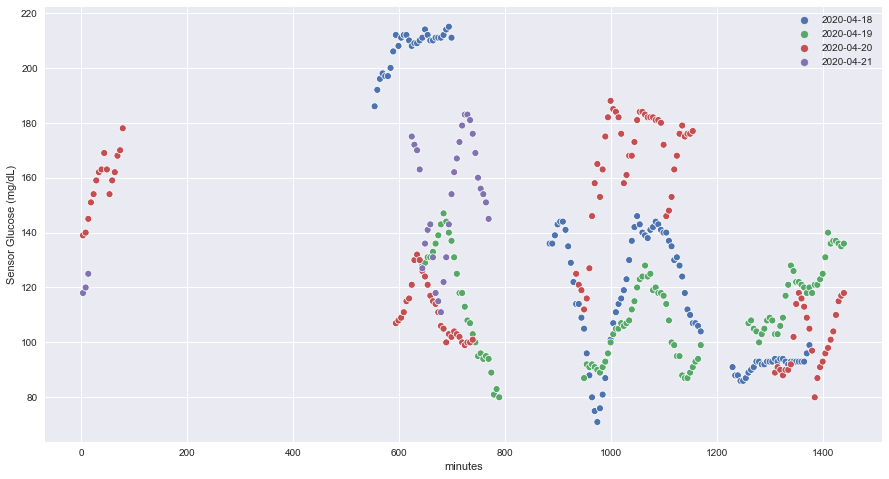

In [86]:
overlapping_dayplot(comidas)

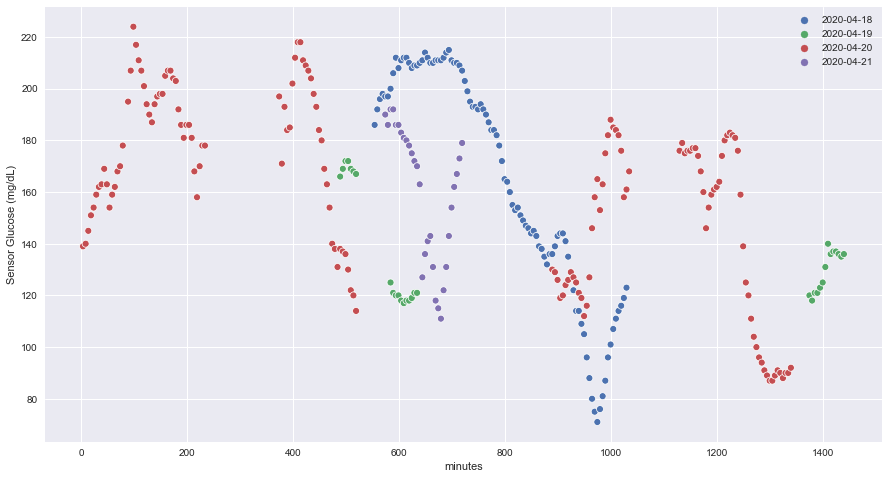

In [80]:
overlapping_dayplot(correcciones)

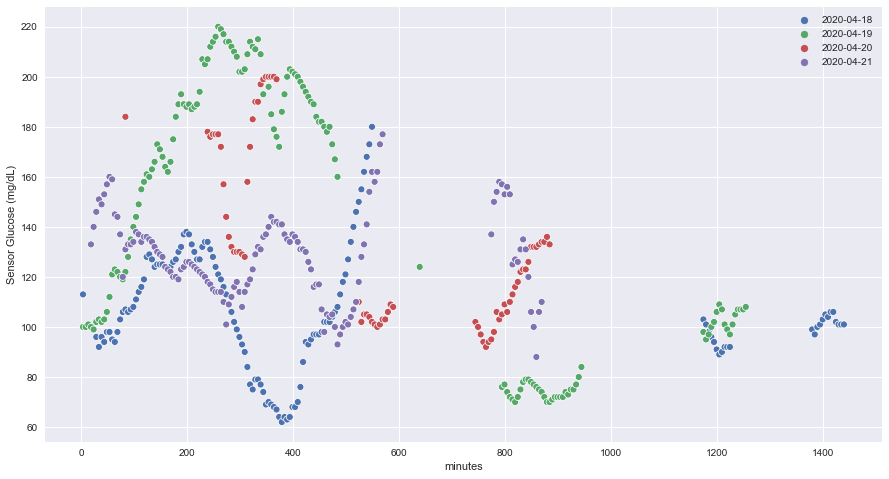

In [69]:
overlapping_dayplot(basal)

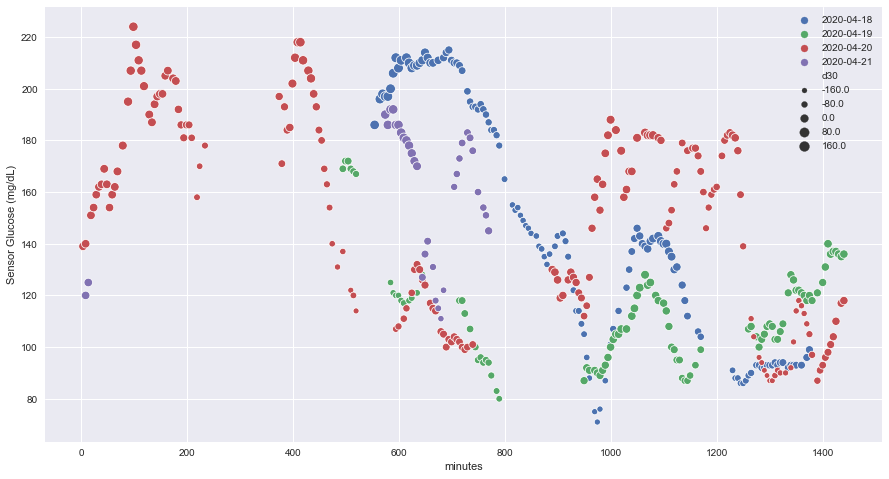

In [63]:
sns.scatterplot(
    data=bolos,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=bolos.index.date,
    size="d30"
)

In [10]:
#dir(idx)

In [9]:
help(idx.drop)

Help on method drop in module pandas.core.indexes.base:

drop(labels, errors='raise') method of pandas.core.indexes.datetimes.DatetimeIndex instance
    Make new Index with passed list of labels deleted.
    
    Parameters
    ----------
    labels : array-like
    errors : {'ignore', 'raise'}, default 'raise'
        If 'ignore', suppress error and existing labels are dropped.
    
    Returns
    -------
    dropped : Index
    
    Raises
    ------
    KeyError
        If not all of the labels are found in the selected axis

